<a href="https://colab.research.google.com/github/suzukimain/image/blob/main/Image_generation_ver_Beta_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title  { run: "auto", display-mode: "code" }
# @markdown # ランタイムをGPUにしてください 
# @markdown ランタイム>ランタイムのタイプを変更>Noneを押す>GPUを選択>決定 
need_to_install = True # or False
if need_to_install:
 !pip install diffusers transformers accelerate scipy safetensors torch --quiet
 !pip install --upgrade  git+https://github.com/Stability-AI/stablediffusion.git transformers accelerate scipy --queit


import os
import pickle
import torch
from IPython.display import display, Markdown 
from datetime import datetime 
import torch 
import ipywidgets as widgets 
from IPython.display import display 
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

#使用するモデルを設定 
model_id = "stabilityai/stable-diffusion-2-1"

#StableDiffusion(メインのモジュール)パイプライン設定 
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


#使用する計算機を設定(GPUがない場合は"cpu"に変更) 
pipe = pipe.to("cuda")

print("画像生成の準備ができました")



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --queit


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


画像生成の準備ができました


  0%|          | 0/50 [00:00<?, ?it/s]

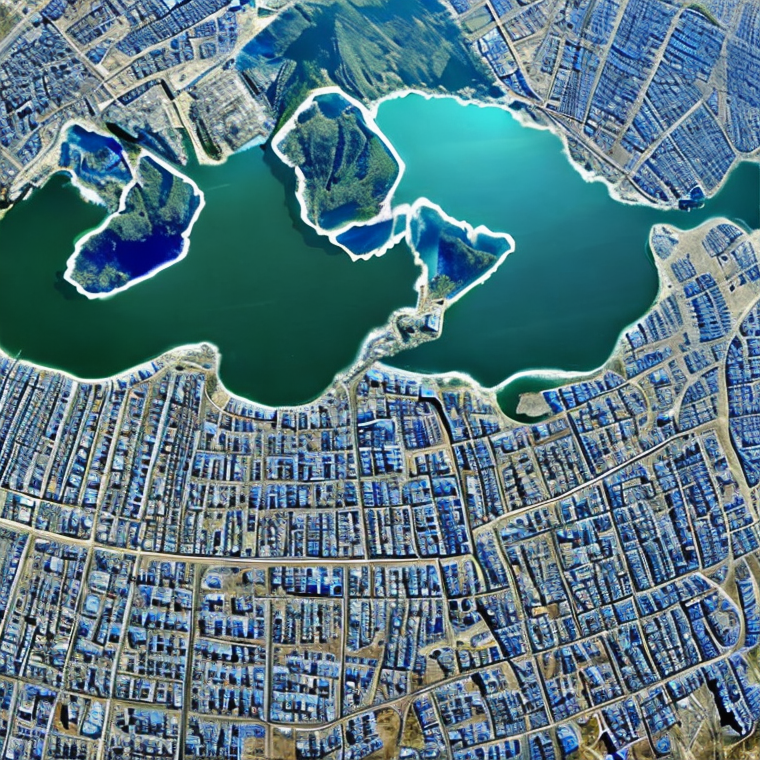

画像生成できました。
*保存先を指定していない場合以下の方法で見れます*左のバー＞生成した画像


In [ ]:
# @markdown #画像生成
# @markdown >ここに数字を入力してください 
生成する枚数 = 1  # @param {type:"number"}  
if 生成する枚数 <= 0 or isinstance(生成する枚数, float): 
    print("\033[31m警告:無効な数字が入力された為デフォルトの1枚に設定しました\033[0m") 
    生成する枚数 = 1 
if 生成する枚数 is None: 
    print("\033[31m警告:無効な形式な為デフォルトの1枚に設定しました\033[0m") 
    生成する枚数 = 1 

# @markdown  (デフォルトでは1回につき1枚生成します。) 

# @markdown  >生成する画像の条件を**英語で**入力してください 
prompt = "earth high resolution"  # @param {type:"string"} 
生成する条件 = prompt
# @markdown 例、"Earth, space, high resolution" や "Please draw a beautiful Mount Fuji with the sun rising from the summit."、"cute, cat" 
人物生成 = False  # @param {type:"boolean"} 
# @markdown 人物生成するときチェックをつけて下さい
# @markdown 

# @markdown >必要であればネガティブプロンプトを入力してください。人物を生成するときにおすすめです
N_prompt = ""  # @param {type:"string"}
# @markdown ネガティブプロンプトとは、**ネガティブな要素を除く**ものです。 例、low quality、unbeautiful.
ネガティブプロンプトをおまかせにする = False  # @param {type:"boolean"}
# @markdown おすすめのネガティブプロンプトをオンにします
ネガティブプロンプトをオフにする = True  # @param {type:"boolean"}
# @markdown ネガティブプロンプトをオフにする
# @markdown >保存する先のパスを入力してください
保存する先のパス = ""  # @param {type:"string"} 
# @markdown  入力しなければ "/content/生成した画像" に保存されます。なければ作るようになっています。 
雰囲気の落ち着き = 0.7  # @param {type:"number"}
温度 = 0.3  # @param {type:"number"}
拡散ステップ = 100  # @param {type:"number"}
縦の解像度 = 760  # @param {type:"number"}
横の解像度 = 760  # @param {type:"number"}
# @markdown  truncation＝雰囲気の落ち着き 0.7くらい

#@markdown temperature＝温度 0.6くらい  要するにどのくらい条件に合わせるかってこと

# @markdown  diffusion_steps＝拡散ステップ 100くらい

# @markdown  height・width＝縦と横の解像度 1024

# @markdown #  オプション 

# @markdown > 生成した画像をGoogleドライブに保存したいときにチェックを入れてください             
 
Googleドライブに接続 = False  # @param {type:"boolean"} 
if Googleドライブに接続: 
    from google.colab import drive 
    drive.mount('/content/drive') 
# @markdown  **チェックをつけると接続に必要な権限を求めるようになります** 

# @markdown

# @markdown #**準備ができたら「画像を生成」というボタンが下に現れます**
# @markdown ボタンを押した後タイムラグがある場合があります。押したら、5秒ほどお待ちください 

# @markdown (なおこの画像生成は "stable diffusion-ver.2" を使用しています)

# ユーザーが入力した文字列を取得する
if not prompt:
    print("\033[1m\033[31m条件の入力がないため一時停止します\033[0m")
    prompt = input("入力した後Enterを押すと再開します。")

import os

def generate_images():
    if 人物生成:
       人物の条件追加 = "Radiant and stunning, with flawless features and a captivating presence. Elegance, grace, and poise come effortlessly to this individual, who exudes confidence and charm. Their eyes sparkle with warmth and intelligence, and their smile is infectious. They are the epitome of beauty and grace, and turn heads wherever they go."
       if ネガティブプロンプトをおまかせにする:
          人物生成用 = (N_prompt + "unbeautiful,Prevent deformities and missing body parts in the generated image of a person. Ensure that the number of fingers is correct, and that the fingers, hands, and face are not deformed or misplaced. Avoid any negative aspects such as unattractive or grotesque appearance, unnatural features or awkward poses. ")
       else:
          人物生成用 = N_prompt
    else:
       人物の条件追加 = "beautiful, cool"
       if  ネガティブプロンプトをおまかせにする:
          人物生成用 = N_prompt
       else:
          人物生成用 = N_prompt +"bat"
    # 生成する条件を設定
    params = {
      "truncation": 雰囲気の落ち着き, # トランクリーション0.7
      "temperature": 温度, # 温度0.6
      "diffusion_steps": 拡散ステップ, # 拡散ステップ100 
      
      }   
    prompt = 生成する条件 + 人物の条件追加
    negative_prompt = 人物生成用+ "blurry, pixelated, noisy, distorted, oversaturated, undersaturated, unrealistic, artificial, unnatural, low-quality"
    num_images = 生成する枚数
    if not ネガティブプロンプトをオフにする:
       prompt += f" but not {negative_prompt}"
    else:
       prompt = prompt
    for i in range(num_images): 
    # ユーザーからの最新入力を使用して画像生成(字下げに注意1文字あける) 
     image = pipe(prompt, height = 縦の解像度 , width = 横の解像度 ).images[0] 
     # イメージを表示
     image.show()
     date = datetime.now().strftime("%Y%m%d_%H%M%S") 
    if 保存する先のパス: 
        if not os.path.exists(保存する先のパス): 
            os.makedirs(保存する先のパス) 
        path = os.path.join(保存する先のパス, date + ".png") 
        image.save(path) 
    else: 
        path = os.path.join('/content/', '生成した画像', date + ".png") 
        if not os.path.exists('/content/生成した画像'): 
            os.makedirs('/content/生成した画像') 
        path = os.path.join('/content/', '生成した画像', date + ".png") 
        image.save(path)

generate_images()
print("画像生成できました。")
print("*保存先を指定していない場合以下の方法で見れます*"
      "左のバー＞生成した画像"
     )